In [32]:
import tensorflow as tf
import numpy as np
import h5py
import tqdm
from evaluator import evaluate_dataset, evaluate_dataset_helper

import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

print(tf.__version__)

2.4.0


Loading model weights


/home/bergamasco/miniconda3/envs/connect2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1.0
Confusion matrix (%):
=-=-=-=-=-=-=-=-=-=-=-
                         Yes       No   <-    Predicted peak 
Actual peak  Yes  >    3.6744     0.2082
              No  >    0.1100     96.0074

 Accuracy: 0.99682
Precision: 0.97094
   Recall: 0.94637
INFO:tensorflow:Assets written to: data/models/model9_tf2_pruned/assets


INFO:tensorflow:Assets written to: data/models/model9_tf2_pruned/assets


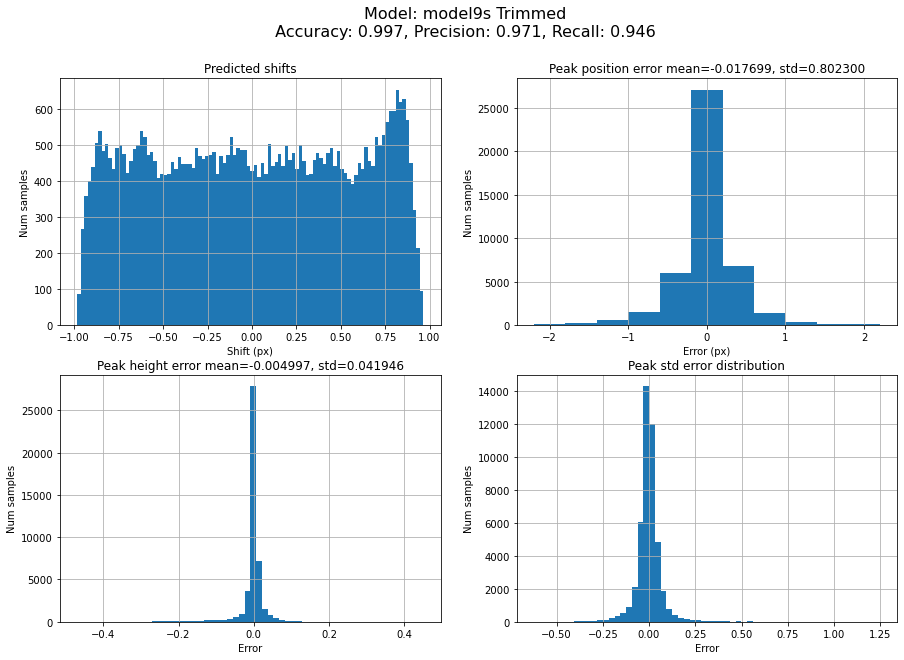

In [35]:
with tf.Graph().as_default():
    from tensorflow.keras.models import model_from_json
    model = None
    with open("data/last_model9_tf2_pruned.json", "r") as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)

    print("Loading model weights")
    model.load_weights("data/last_model9_tf2_pruned.h5")
    
    from evaluator import evaluate_dataset
    evaluate_dataset( "data/test_100k_64.h5", model, model_name="model9s Trimmed" )
    
    # Save as a standard TF model
    model.save('data/models/model9_tf2_pruned')
    

# Convert to Tflite model

## Dynamic range quantization (8-bit weights)

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model('data/models/model9_tf2_pruned') 
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('data/models/model9_tf2_pruned_dynrange.tflite', 'wb') as f:
    f.write(tflite_model)

## Float 16 quantization (float16 weights)

In [5]:
converter = tf.lite.TFLiteConverter.from_saved_model('data/models/model9_tf2_pruned') 
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the model.
with open('data/models/model9_tf2_pruned_float16.tflite', 'wb') as f:
    f.write(tflite_model)

## Full integer quantization (int8 weights+input/output)

In [7]:
def create_data_generator():

    with h5py.File("data/train_100k_64.h5",'r') as f:
        x_train = np.array( f["x"][0:2000,...] )

        def representative_data_gen():
            for ii in range( x_train.shape[0] ):
                yield [ np.expand_dims(x_train[ii,...], axis=0) ]
            
        return representative_data_gen
        
dg = create_data_generator()
for ii in dg():
    print(ii[0].shape)
    break
    
    
converter = tf.lite.TFLiteConverter.from_saved_model('data/models/model9_tf2_pruned') 
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = create_data_generator()

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Save the model.
with open('data/models/model9_tf2_pruned_int8.tflite', 'wb') as f:
    f.write(tflite_model)

(1, 1024, 1)


# Test model

In [57]:
# Load the TFLite model and allocate tensors.

#model_name = "Int8 weights / IO float32"
#interpreter = tf.lite.Interpreter(model_path='data/models/model9_tf2_pruned_dynrange.tflite')

#model_name = "Float16 weights & IO"
#interpreter = tf.lite.Interpreter(model_path='data/models/model9_tf2_pruned_float16.tflite')

model_name = "Int8 weights & IO"
interpreter = tf.lite.Interpreter(model_path='data/models/model9_tf2_pruned_int8.tflite')

interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_type = input_details[0]['dtype']
input_scale, input_zero_point = input_details[0]["quantization"]
output_shape = output_details[0]['shape']
output_type = output_details[0]['dtype']
output_scale, output_zero_point = output_details[0]["quantization"]

print("Model details")
print("------------------")
print("Input: ")
print(input_details)
print(input_type)
print(input_scale)
print(input_zero_point)

print("Output: ")
print(output_details)
print(output_type)
print(output_scale)
print(output_zero_point)

Model details
------------------
Input: 
[{'name': 'serving_default_input_1:0_int8', 'index': 0, 'shape': array([   1, 1024,    1], dtype=int32), 'shape_signature': array([  -1, 1024,    1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
<class 'numpy.int8'>
1.0
-128
Output: 
[{'name': 'StatefulPartitionedCall:0_int8', 'index': 84, 'shape': array([ 1, 64,  4], dtype=int32), 'shape_signature': array([-1, 64,  4], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.009283420629799366, -22), 'quantization_parameters': {'scales': array([0.00928342], dtype=float32), 'zero_points': array([-22], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
<class 'numpy.int8'>
0.009283420629799366
-22


  0%|          | 73/19405 [00:00<00:26, 721.02it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(19405, 1024, 1)
Predicting...


100%|██████████| 19405/19405 [00:27<00:00, 704.80it/s]


(19405, 64, 4)
1.0
Confusion matrix (%):
=-=-=-=-=-=-=-=-=-=-=-
                         Yes       No   <-    Predicted peak 
Actual peak  Yes  >    3.6742     0.2084
              No  >    0.1120     96.0054

 Accuracy: 0.99680
Precision: 0.97042
   Recall: 0.94633


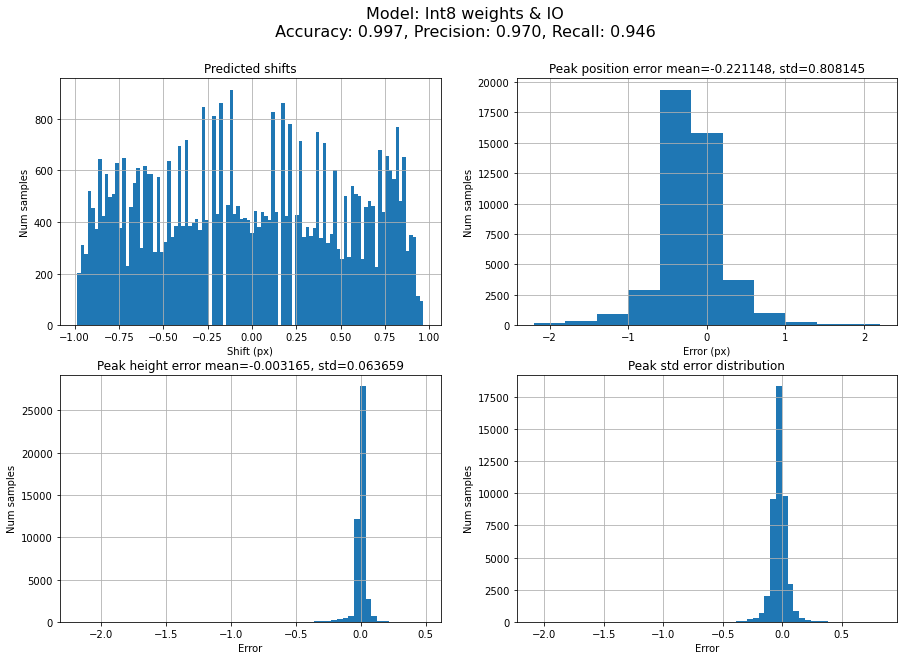

In [59]:
%load_ext autoreload
%autoreload 1
%aimport evaluator

with h5py.File("data/test_100k_64.h5",'r') as f:
    x_test = np.array( f["x"] )
    y_test = np.array( f["y"] )
    print(x_test.shape)
    y_pred = []
    
    print("Predicting...")
    for ii in tqdm.trange( x_test.shape[0]):
        
        data = np.expand_dims(x_test[ii,...], axis=0)
        if input_type == np.int8:
            data = ( data/input_scale + input_zero_point ).astype(np.int8)
        
        interpreter.set_tensor( input_details[0]['index'], data )
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        if output_type == np.int8:
            output_data = (output_data-output_zero_point).astype(np.float32)*output_scale
            
        y_pred.append( np.squeeze(output_data) )

    y_pred = np.array( y_pred )
    print(y_pred.shape)
    
    (accuracy, pos_mean, pos_std, h_mean, h_std, precision, recall) = evaluate_dataset_helper( y_pred, y_test, saveplots=True, model_name=model_name )